In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install imutils

In [3]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
#from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import tensorflow as tf
import keras
#from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
#from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#from keras.preprocessing.image import ImageDataGenerator
import imutils
import itertools

In [4]:
def getImgContours(edged):
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

In [5]:
def getBoxes(contours, orig):
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

In [12]:

def findEdges(image):
    # find edges in image
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

In [6]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)

# Load Image Using Generator


In [7]:
BATCH_SIZE = 32 
VALIDATION_SPLIT = 0.2 
EPOCHS = 30 

In [8]:
TRAIN_PATH = "/content/drive/MyDrive/BME2/dataset2-master/images/TRAIN"
TEST_PATH = "/content/drive/MyDrive/BME2/dataset2-master/images/TEST"

In [9]:
# we create two instances with the same arguments
data_gen_args = dict(validation_split=VALIDATION_SPLIT,
                     rotation_range=45,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     shear_range=0.2,
                     fill_mode='nearest')
image_datagen = ImageDataGenerator(**data_gen_args)
test_datagen = ImageDataGenerator()

# Provide the same seed and keyword arguments to the fit and flow methods

#image_datagen.fit(X_train)
train_generator = image_datagen.flow_from_directory(TRAIN_PATH,
    target_size=(120, 120),
    color_mode="rgb",
    shuffle=True,
    interpolation="nearest",
    class_mode="categorical",
    batch_size = BATCH_SIZE,
    subset='training')
val_generator = image_datagen.flow_from_directory(TRAIN_PATH,
    target_size=(120, 120),
    color_mode="rgb",
    shuffle=False,
    interpolation="nearest",
    class_mode="categorical",
    batch_size = BATCH_SIZE,
    subset='validation')

test_generator = test_datagen.flow_from_directory(TEST_PATH,
                        target_size=(120, 120),
                        color_mode="rgb",
                        shuffle=False,
                        class_mode='categorical',
                        batch_size=BATCH_SIZE,
                        interpolation="nearest")
#val_generator = image_datagen.flow(X_val1, Y_val1, batch_size=2)

training_sammples = train_generator.samples
valid_samples = val_generator.samples
test_samples = test_generator.samples

NameError: ignored

In [ ]:
#Khởi tạo model
n_classes = 4
input_shape = (120, 120)
model = Sequential()
#1
model.add(Conv2D(16 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (120,120,3)))
model.add(Conv2D(16 , (3,3), padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

#2
model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

#3
model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

#4
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

#5
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

#Fully Connected
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'tanh'))
model.add(Dropout(0.7))
model.add(Dense(units = 128 , activation = 'tanh'))
model.add(Dropout(0.5))
model.add(Dense(units = 64 , activation = 'tanh'))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(units = 4 , activation = 'softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

In [ ]:
def scheduler(epoch, lr):
    # Nếu dưới 5 epoch
    if epoch < 10:
        # Trả về lr
        return float(lr)
    else:
        # Còn không thì trả vềa
        return float(lr * 1e-2)
callback1 = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
callback3 = tf.keras.callbacks.ModelCheckpoint(
                            filepath="/content/drive/MyDrive/CBIS/includePatch2.h5",
                            save_weights_only=True,
                            monitor='val_accuracy',
                            mode='max',
                            save_best_only=True,
                            verbose=1)


def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics='accuracy')

In [ ]:
checkpoint = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

history = model.fit(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=val_generator,
              validation_steps=valid_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS,
              callbacks=[learning_rate_reduction])


In [ ]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(20)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()


In [ ]:
plot_accuracy_loss_chart(history)

In [ ]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Load Image Using Os


In [13]:
IMAGE_SIZE = 120
EPOCHS = 20

In [14]:

datasets = ['/content/drive/MyDrive/BME2/dataset2-master/images/TRAIN', '/content/drive/MyDrive/BME2/dataset2-master/images/TEST']
images = []
labels = []
  #lặp qua các folder trong thư mục datasets
count =0
for dataset in datasets:

    for folder in os.listdir(dataset):

        if folder in ['EOSINOPHIL']: label = 0
        elif folder in ['LYMPHOCYTE']: label = 1
        elif folder in ['MONOCYTE']: label = 2
        elif folder in ['NEUTROPHIL']: label = 3

        for file in tqdm(os.listdir(os.path.join(dataset, folder))):

            img_path = os.path.join(os.path.join(dataset, folder), file)

            # Open 
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # add padding to the image to better detect cell at the edge
            image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
            
            #thresholding the image to get the target cell
            image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
            
            # openning errosion then dilation
            kernel = np.ones((3, 3), np.uint8)
            kernel1 = np.ones((5, 5), np.uint8)
            img_erosion = cv2.erode(image1, kernel, iterations=2)
            image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
            
            #detecting the blood cell
            edgedImage = findEdges(image1)
            edgedContours = getImgContours(edgedImage)
            edgedBoxes =  getBoxes(edgedContours, image.copy())
            if len(edgedBoxes)==0:
                count +=1
                continue
            # get the large box and get its cordinate
            last = edgedBoxes[-1]
            max_x = int(max(last[:,0]))
            min_x = int( min(last[:,0]))
            max_y = int(max(last[:,1]))
            min_y = int(min(last[:,1]))
            
            # draw the contour and fill it 
            mask = np.zeros_like(image)
            cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
            
            # any pixel but the pixels inside the contour is zero
            image[mask==0] = 0
            
            # extract th blood cell
            image = image[min_y:max_y, min_x:max_x]

            if (np.size(image)==0):
                count +=1
                continue
            # resize th image
            image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

images = np.array(images, dtype = 'float32')
labels = np.array(labels, dtype = 'int32')



100%|██████████| 620/620 [03:01<00:00,  3.41it/s]


In [15]:
print(len(images))
print(len(labels))

12146
12146


In [16]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [17]:
print(len(train_images))
print(len(train_labels))
print(len(val_images))
print(len(val_labels))
print(len(test_images))
print(len(test_labels))

9716
9716
1215
1215
1215
1215


In [18]:

print("Training images: {}".format(train_images.shape))
print("Training labels: {}".format(train_labels.shape))
print("Validation images: {}".format(val_images.shape))
print("Validation labels: {}".format(val_labels.shape))
print("Test images: {}".format(test_images.shape))
print("Test labels: {}".format(test_labels.shape))

Training images: (9716, 120, 120, 3)
Training labels: (9716,)
Validation images: (1215, 120, 120, 3)
Validation labels: (1215,)
Test images: (1215, 120, 120, 3)
Test labels: (1215,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9716


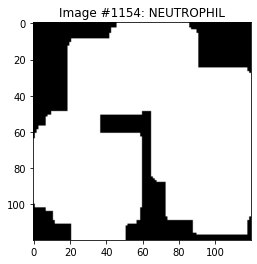

In [19]:
#hiển thị train image  
print(len(train_images))
index = np.random.randint(train_images.shape[0])
plt.figure()
plt.imshow(train_images[index])
plt.title('Image #{}: '.format(index) + class_names[train_labels[index]])
plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Ground Truth : 2')

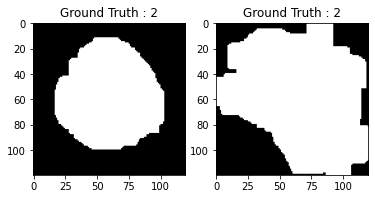

In [20]:
# Ground truth
# Hiển thị ảnh từ train data
plt.subplot(121)
index = np.random.randint(train_images.shape[0])
plt.imshow(train_images[index,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[index]))

# Hiển thị ảnh từ test data
plt.subplot(122)
index = np.random.randint(test_images.shape[0])
plt.imshow(test_images[index,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[index]))



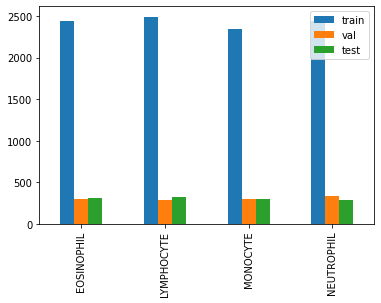

In [21]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

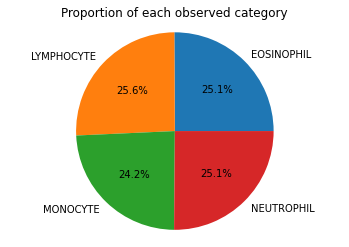

In [22]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [23]:
#Normalization
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

9716


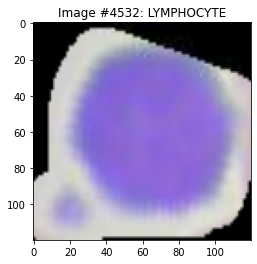

In [24]:
def display_random_image (class_names, images, labels):
    print(len(images))
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

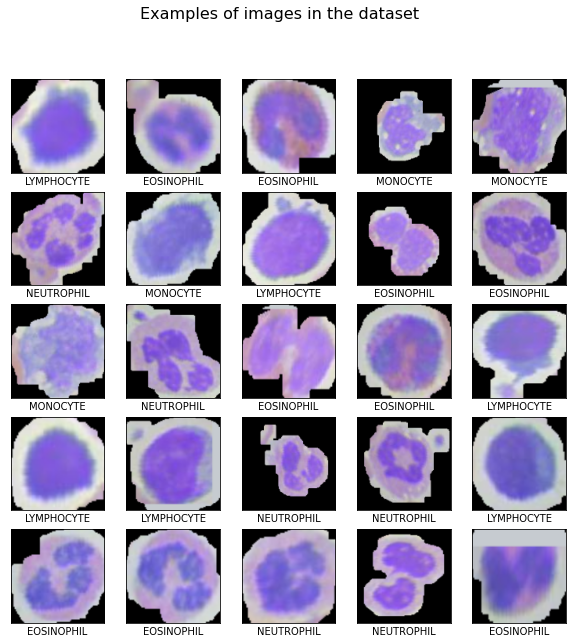

In [25]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

In [38]:
CNN = Sequential()

#1
CNN.add(Conv2D(16 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)))
CNN.add(Conv2D(16 , (3,3), padding = 'same' , activation = 'relu'))
CNN.add(MaxPooling2D(pool_size = (2,2)))

#2
CNN.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
CNN.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size = (2,2)))

#3
CNN.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
CNN.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size = (2,2)))

#4
CNN.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
CNN.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size = (2,2)))
CNN.add(Dropout(0.2))

#5
CNN.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
CNN.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size = (2,2)))
CNN.add(Dropout(0.2))

#Fully Connected
CNN.add(Flatten())
CNN.add(Dense(units = 512 , activation = 'tanh'))
CNN.add(Dropout(0.7))
CNN.add(Dense(units = 128 , activation = 'tanh'))
CNN.add(Dropout(0.5))
CNN.add(Dense(units = 64 , activation = 'tanh'))
CNN.add(Dropout(0.3))
CNN.add(Flatten())

CNN.add(Dense(units = 4 , activation = 'softmax'))

CNN.compile(optimizer = "adam" , 
               loss = 'sparse_categorical_crossentropy' , 
               metrics = ['accuracy'])
CNN.summary()

callback1 = ModelCheckpoint(filepath='/content/drive/MyDrive/BME2/best_model.hdf5', 
                            save_best_only=True, save_weights_only=True,
                            monitor='val_accuracy',mode='max',verbose=1)
callback2 = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
callback3 = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

historyCNN = CNN.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = EPOCHS, 
    validation_data=(val_images, val_labels), 
    callbacks=[callback1, callback3])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 120, 120, 16)      448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 120, 120, 16)      2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 60, 60, 16)        0         
_________________________________________________________________
separable_conv2d_24 (Separab (None, 60, 60, 32)        688       
_________________________________________________________________
separable_conv2d_25 (Separab (None, 60, 60, 32)        1344      
_________________________________________________________________
batch_normalization_12 (Batc (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 30, 32)       

In [39]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(EPOCHS)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()


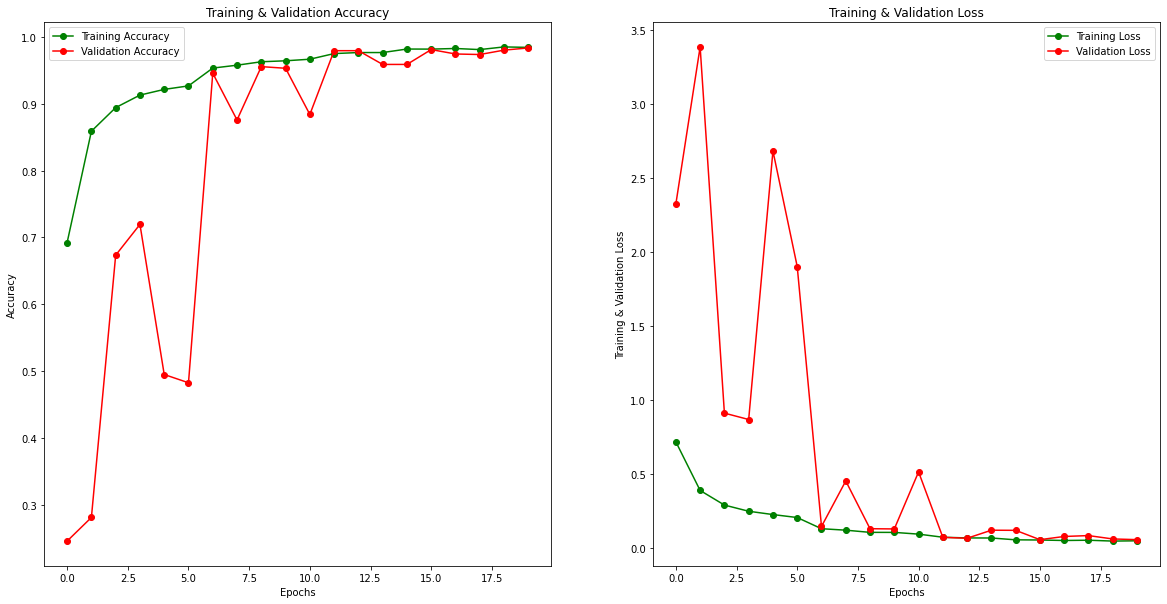

In [40]:
plot_accuracy_loss_chart(historyCNN)

In [41]:
results = CNN.evaluate(test_images, test_labels)

print("Loss of test model is  ", results[0])
print("Accuracy of test model is ", results[1]*100, "%")


results = CNN.evaluate(val_images, val_labels)

print("Loss of validation model is ", results[0])
print("Accuracy of validation model is ", results[1]*100, "%")

results = CNN.evaluate(train_images, train_labels)

print("Loss of train model  is ", results[0])
print("Accuracy of train model is ", results[1]*100, "%")

38/38 [==============================] - 9s 237ms/step - loss: 0.0541 - accuracy: 0.9852
Loss of test model is   0.054092131555080414
Accuracy of test model is  98.51852059364319 %
38/38 [==============================] - 9s 239ms/step - loss: 0.0578 - accuracy: 0.9835
Loss of validation model is  0.05782207101583481
Accuracy of validation model is  98.35391044616699 %
304/304 [==============================] - 72s 237ms/step - loss: 0.0230 - accuracy: 0.9922
Loss of train model  is  0.0230023805052042
Accuracy of train model is  99.21778440475464 %


In [42]:
CNN.save('/content/drive/MyDrive/BME2/Bloodcell_Classification_CNN_Custom_Build_20_epochs.h5')

In [43]:
from sklearn.metrics import classification_report

predictions = CNN.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([1, 2, 0, 0, 1, 1, 0, 2, 2, 1, 0, 1, 1, 3, 2])

In [44]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['EOSINOPHIL - 0', 'LYMPHOCYTE - 1', 'MONOCYTE - 2', 'NEUTROPHIL - 3']))

                precision    recall  f1-score   support

EOSINOPHIL - 0       0.97      0.97      0.97       305
LYMPHOCYTE - 1       1.00      1.00      1.00       326
  MONOCYTE - 2       1.00      1.00      1.00       295
NEUTROPHIL - 3       0.97      0.97      0.97       289

      accuracy                           0.99      1215
     macro avg       0.98      0.98      0.98      1215
  weighted avg       0.99      0.99      0.99      1215



In [45]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm

,0,1,2,3
0,297,0,0,8
1,0,326,0,0
2,0,0,295,0
3,9,0,1,279


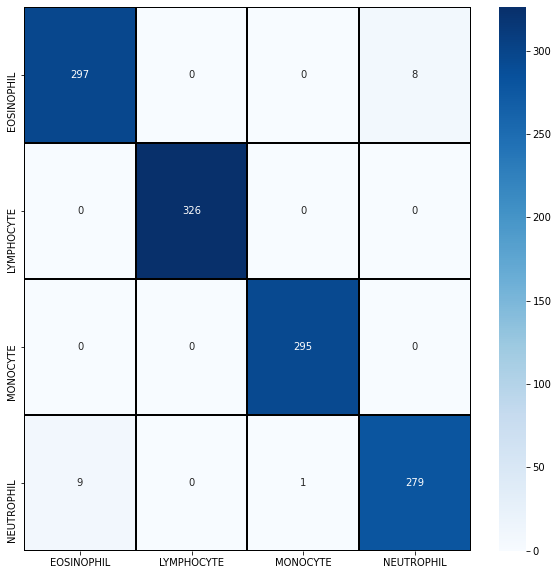

In [46]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)